In [1]:
import os
import sys
os.chdir('../')
new_current_dir = os.getcwd()  # get new current working directory
print("New current directory:", new_current_dir)
sys.path.append('./src/python/')

# import
from preamble.preamble import *
from gamma.gamma import GammaNPP
from gamma.rules import make_rules, Rules, readable_rules
from gamma.common import npp_from_json, set_of_frozenset
from plot.plot_function import *

New current directory: /home/fiftyfour/Documents/NetworkPricingGraphContraction


In [2]:
with open('./tmp/result_original.pkl', 'rb') as f:
    original_result = pickle.load(f)

In [3]:
cols_header = list(original_result['d30-01'].keys())
cols_header.remove('edge')
rows_header = list(original_result.keys())

original_meta_data = [
                [r[k] for k in cols_header] for r in original_result.values()
            ]
original_meta_data = pd.DataFrame(original_meta_data, index=rows_header,columns=cols_header)
original_meta_data['finish'] = original_meta_data['finish'].astype(bool)
original_meta_data['finish'] = original_meta_data['finish'].astype(int)

# tmp = meta_data_df[(meta_data_df['finish']==1) & (meta_data_df['solve_time']<=float(1000))]
# Creating a config for the server
# config = {}
# for pb_name, row in tmp.iterrows():
#     sh_time_limit = int(round(row['solve_time'] + 100,0)) # sec
#     config[pb_name] = sh_time_limit

# with open('./result/time_limit_config.pkl', 'wb') as f:
#     pickle.dump(config, f)

In [4]:
# data on one problem
pb_list = [
            'd30-01','d30-02','d30-03','d30-05','d30-06','d30-07','d30-08','d30-09',
            'g30-01','g30-02','g30-03','g30-04','g30-05','g30-06','g30-07','g30-08','g30-09',
            'h30-01','h30-03','h30-07','h30-09',
            'v30-01','v30-05','v30-06','v30-07','v30-08'
            ]
result_dict = {}
for problem_name in pb_list:

    result = {}
    with open(f'./tmp/result_{problem_name}.pkl', 'rb') as f:
        result[f'000000-000000-0-0-0-0-0-0-0-0-0-{problem_name}'] = original_result[problem_name]
        result.update(pickle.load(f))
        
    rows_header = list(map(lambda x: x[0], result[f'000000-000000-0-0-0-0-0-0-0-0-0-{problem_name}']['edge']))
    cols_header = list(result.keys())
    edge_index_data = [      
                        [ r['edge'][i][1] for r in result.values() ] 
                        for i,_ in enumerate(rows_header)   
                    ]
    edge_value_data = [      
                        [ r['edge'][i][2] for r in result.values() ] 
                        for i,_ in enumerate(rows_header)   
                    ]
    
    flow_value_data = [      
                        [ r['edge'][i][3] for r in result.values() ] 
                        for i,_ in enumerate(rows_header)   
                    ]
    # Table of the form
    #  edge v1 v2 v3 v4 ....
    #   e1  o11
    #   e2  o21
    #   e3  ...
    # ....
    edge_index_df = pd.DataFrame(edge_index_data, index = rows_header, columns=cols_header)
    edge_value_df = pd.DataFrame(edge_value_data, index = rows_header, columns=cols_header)
    flow_value_df = pd.DataFrame(flow_value_data, index = rows_header, columns=cols_header)
    
    
    ## meta_data
    # df of the form
    #  pb v1 v2 v3 v4 ....
    #   p1  o11
    #   p2  o21
    #   p3  ...
    # ....
    cols_header = list(result[f'000000-000000-0-0-0-0-0-0-0-0-0-{problem_name}'].keys())
    cols_header.remove('edge')
    rows_header = list(result.keys())
    
    meta_data = [
                    [r[k] for k in cols_header] for r in result.values()
                ]
    meta_data_df = pd.DataFrame(meta_data, index=rows_header,columns=cols_header)
    meta_data_df[['min_sl', 'max_sl', 'm', 'H4']] = meta_data_df[['min_sl', 'max_sl', 'm', 'H4']].astype(int)
    meta_data_df['finish'] = meta_data_df['finish'].astype(bool)
    meta_data_df['finish'] = meta_data_df['finish'].astype(int)
    
    o_obj = meta_data_df['obj_value'][f'000000-000000-0-0-0-0-0-0-0-0-0-{problem_name}']
    o_time = meta_data_df['solve_time'][f'000000-000000-0-0-0-0-0-0-0-0-0-{problem_name}']
    o_n_tolled = meta_data_df['n_tolled'][f'000000-000000-0-0-0-0-0-0-0-0-0-{problem_name}']
    
    meta_data_df['optimal_ratio'] = meta_data_df['obj_value']/o_obj
    meta_data_df['time_ratio'] = meta_data_df['solve_time']/o_time
    meta_data_df['tolled_ratio'] = meta_data_df['n_tolled']/o_n_tolled

    columns = ['min_sl', 'max_sl', 'm', 'H4']
    meta_data_df['Class'] = meta_data_df[columns].astype(str).apply('-'.join, axis=1)
    
    result_dict[problem_name] = {
                                'edge_index_df':edge_index_df.copy(),
                                'edge_value_df':edge_value_df.copy(),
                                'flow_value_df':flow_value_df.copy(),
                                'meta_data_df':meta_data_df.copy()
    }

merged_df = pd.DataFrame()
for pb_name in result_dict:
    merged_df = pd.concat([merged_df, result_dict[pb_name]['meta_data_df']])
merged_df = merged_df.T.filter(regex=r'^(?!000000-000000-0-0-0-0-0-0-0-0-0-.*).*$').T

result_dict['combined'] = {
                            'edge_index_df':None,
                            'edge_value_df':None,
                            'flow_value_df':None,
                            'meta_data_df':merged_df.copy()
                        }

In [5]:
result_dict['combined']['meta_data_df'].head(5)

obj_value preprocess_time  solve_time  \
000033-100-2-5-0-1-1-1-1-1500-d30-01  122699.0        2.677819  223.492042   
000049-100-2-5-0-1-1-1-1-1500-d30-01  119630.0        1.434309   54.771206   
000056-100-2-5-0-1-1-1-1-1500-d30-01  124682.0        2.406669  160.495974   
000050-100-2-5-0-1-1-1-1-1500-d30-01  111996.0        2.938322  371.345754   
000006-100-2-5-0-1-1-1-1-1500-d30-01  121525.0        1.989639  210.636301   

                                     n_vertex n_edge n_tolled  \
000033-100-2-5-0-1-1-1-1-1500-d30-01      141    831      163   
000049-100-2-5-0-1-1-1-1-1500-d30-01      141    831      163   
000056-100-2-5-0-1-1-1-1-1500-d30-01      143    833      165   
000050-100-2-5-0-1-1-1-1-1500-d30-01      139    829      161   
000006-100-2-5-0-1-1-1-1-1500-d30-01      142    832      164   

                                                                    compression_factors  \
000033-100-2-5-0-1-1-1-1-1500-d30-01  {1: 1.0036101083032491, 2: 1.0212765957446808,...   
000049-100-2-5-0-1-1-1-1-1500-d30-01  {1: 1.0036101083032491, 2: 1.0212765957446808,...   
000056-100-2-5-0-1-1-1-1-1500-d30-01  {1: 1.0012004801920769, 2: 1.006993006993007, ...   
000050-100-2-5-0-1-1-1-1-1500-d30-01  {1: 1.006031363088058, 2: 1.0359712230215827, ...   
000006-100-2-5-0-1-1-1-1-1500-d30-01  {1: 1.0024038461538463, 2: 1.0140845070422535,...   

                                     rewind_optimal_1 rewind_time_1  \
000033-100-2-5-0-1-1-1-1-1500-d30-01            99086      0.023457   
000049-100-2-5-0-1-1-1-1-1500-d30-01            74263      0.020335   
000056-100-2-5-0-1-1-1-1-1500-d30-01           117366      0.025497   
000050-100-2-5-0-1-1-1-1-1500-d30-01            86609      0.021861   
000006-100-2-5-0-1-1-1-1-1500-d30-01            84193      0.020504   

                                     rewind_optimal_2  ...  m H1 H2 H3 H4  \
000033-100-2-5-0-1-1-1-1-1500-d30-01            95521  ...  0  1  1  1  1   
000049-100-2-5-0-1-1-1-1-1500-d30-01            74263  ...  0  1  1  1  1   
000056-100-2-5-0-1-1-1-1-1500-d30-01           117366  ...  0  1  1  1  1   
000050-100-2-5-0-1-1-1-1-1500-d30-01            85349  ...  0  1  1  1  1   
000006-100-2-5-0-1-1-1-1-1500-d30-01            84193  ...  0  1  1  1  1   

                                     max_attemp optimal_ratio time_ratio  \
000033-100-2-5-0-1-1-1-1-1500-d30-01       1500      0.984467   0.825241   
000049-100-2-5-0-1-1-1-1-1500-d30-01       1500      0.959843   0.202242   
000056-100-2-5-0-1-1-1-1-1500-d30-01       1500      1.000377   0.592629   
000050-100-2-5-0-1-1-1-1-1500-d30-01       1500      0.898592   1.371189   
000006-100-2-5-0-1-1-1-1-1500-d30-01       1500      0.975047   0.777771   

                                     tolled_ratio    Class  
000033-100-2-5-0-1-1-1-1-1500-d30-01     0.981928  2-5-0-1  
000049-100-2-5-0-1-1-1-1-1500-d30-01     0.981928  2-5-0-1  
000056-100-2-5-0-1-1-1-1-1500-d30-01     0.993976  2-5-0-1  
000050-100-2-5-0-1-1-1-1-1500-d30-01      0.96988  2-5-0-1  
000006-100-2-5-0-1-1-1-1-1500-d30-01     0.987952  2-5-0-1  

[5 rows x 25 columns]

TypeError: density_kdeplot() missing 2 required positional arguments: 'x_' and 'crosshairs'

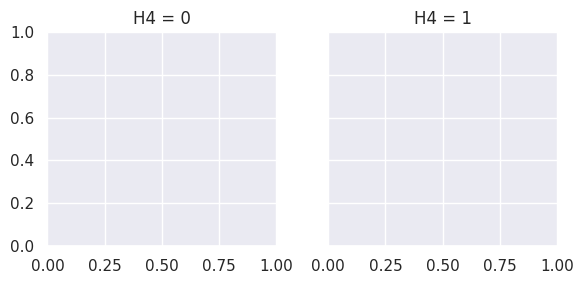

In [14]:
sns.set(style='darkgrid')

plot_kwargs = {
                'ticks_font_size':16/2,
                'label_font_size':22/2,
                'title_font_size':26/2,
                'legend_font_size':18/2,
                'fig_x_size':15/2,
                'fig_y_size':15/2,
                'x_label':'',
                'y_label':'',
                'title':'',
              }


# p = edge_edge_variance_histplot(edge_value_df,problem_name,**plot_kwargs)
# plt.show()
# p = edge_edge_mean_histplot(edge_value_df,problem_name,**plot_kwargs)
# plt.show()
# p = flow_flow_variance_histplot(flow_value_df,problem_name,**plot_kwargs)
# plt.show()
# p = flow_flow_mean_histplot(flow_value_df,problem_name,**plot_kwargs)
# plt.show()
# p = objective_objective_histplot(meta_data_df,problem_name,**plot_kwargs)
# plt.show()
# p = time_histplot(meta_data_df,problem_name,**plot_kwargs)
# plt.show()

g = sns.FacetGrid(merged_df, col="H4",)
g.map(density_kdeplot, x_"optimal_ratio")

# # Optimal ratio H4=1
# plot_kwargs['x_label'] = 'Optima`l ratio'
# plot_kwargs['title'] = 'Optimal ratio (H4=1)'
# p = density_kdeplot(merged_df[merged_df['H4'] == 1], x_='optimal_ratio', crosshairs=(1,), legend=True, **plot_kwargs)

# # Time ratio H4=0
# plot_kwargs['title'] = 'Time ratio (H4=0)'
# plot_kwargs['x_label'] = 'Time ratio'
# p = density_kdeplot(merged_df[merged_df['H4'] == 0], x_='time_ratio', crosshairs=(1,), legend=True, **plot_kwargs)



# # Optimal ratio H4=0
# plot_kwargs['title'] = 'Optimal ratio (H4=0)'
# p = density_kdeplot(df=merged_df[merged_df['H4']==0], x_='optimal_ratio', crosshairs=(1,), legend=True, **plot_kwargs)
# plt.show()

# # Time ratio H4=1
# plot_kwargs['title'] = 'Time ratio (H4=1)'
# plot_kwargs['x_label'] = 'Time ratio'
# p = density_kdeplot(df=merged_df[merged_df['H4']==1], x_='time_ratio', crosshairs=(1,), legend=True, **plot_kwargs)
# plt.show()


# p = ratio_density(merged_df,  ratio='optimal_ratio', H4=1, legend=True, **plot_kwargs)
# plt.show()
# p = ratio_density(merged_df, ratio='optimal_ratio', H4=0, legend=True, **plot_kwargs)
# plt.show()



# p = ratio_density(merged_df,  ratio='time_ratio', H4=1, legend=True, **plot_kwargs)
# plt.show()
# p = ratio_density(merged_df, ratio='time_ratio', H4=0, legend=True, **plot_kwargs)
# plt.show()


# p=optimal_ratio_vs_time_ratio(merged_df, H4=1, log_scale=True, **plot_kwargs)
# plt.show()
# p=optimal_ratio_vs_time_ratio(merged_df, H4=0,log_scale=True, **plot_kwargs)
# plt.show()







# # p = solve_time_density(result_dict['d30-01']['meta_data_df'], pb_name='d30-01', H4=1, legend=True, **plot_kwargs)
# # plt.show()
# # p = solve_time_density(result_dict['d30-01']['meta_data_df'], pb_name='d30-01', H4=0, legend=True, **plot_kwargs)
# # plt.show()

# # plot_kwargs['fig_x_size'] = 20/2
# # plot_kwargs['fig_y_size'] = 10/2


plot_kwargs['title'] ='Correlation matrix'
p=correlation_matrix(merged_df, columns=['optimal_ratio', 'time_ratio', 'tolled_ratio', 'H4'],  **plot_kwargs)
plt.show()

In [7]:
df = merged_df.copy()
df['time_ratio_log'] = np.log(df['time_ratio'])
df = df.T.filter(regex=r'^(?!000000-000000-0-0-0-0-0-0-0-0-0-.*).*$').T

for H4 in [0, 1]:
    classes = df[df['H4'] == H4]['Class'].unique()
    classes = sorted(classes, key=lambda x: list(map(int, x.split('-')[:3])))
    if H4 == 0:
        fig, axs = plt.subplots(ncols=2, nrows=len(classes), figsize=(16, 100))
    for i, cls in enumerate(classes):
        data = df[(df['H4']==H4) & (df['Class']==cls)]
        sns.kdeplot(data=data, x="time_ratio_log", y="optimal_ratio", ax=axs[i, H4], alpha=.25, cmap="rocket_r", fill=True)
        axs[i,H4].set_title(cls)
        axs[i,H4].set_ylim(0.5, 1.5)
        axs[i,H4].set_xlim(-5, 5)
        axs[i,H4].axhline(y=1, color='red', linestyle='--')
        axs[i,H4].axvline(x=0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

TypeError: loop of ufunc does not support argument 0 of type float which has no callable log method

In [ ]:
# Pour comparer les classes avec les vrais arcs
# for col in edge_index_df.columns:
#     if not col == f'000000-000000-0-0-0-0-0-0-0-0-0-{problem_name}':
#         t2 = edge_index_df[col].values
#         freq = {}
#         for x2 in t2:
#             if not x2 in freq:
#                 freq[x2] = 1
#             else:
#                 freq[x2] += 1
        
#         sp = list(filter(lambda x: freq[x]>=2, freq))
#         for ii in sp:
#             idx = edge_index_df[col][edge_index_df[col]==ii].index
#             print('after')
#             print(edge_value_df[col][idx])
    
    
            
#             print('original')
#             print(edge_value_df[f'000000-000000-0-0-0-0-0-0-0-0-0-{problem_name}'][idx])
#             print(sum(edge_value_df[f'000000-000000-0-0-0-0-0-0-0-0-0-{problem_name}'][idx].values))
#             input()

In [34]:
file_time_config = './result/time_limit_config.pkl'
directory_npp = './data/generated/problems/paper/'
directory_sh = './src/sh/'
grouped = False
with open(file_time_config,'rb') as f:
    config = pickle.load(f)
test = [
'./data/generated/problems/paper/d35-08/000001-000099-d35-08-P.json',
'./data/generated/problems/paper/d35-01/000001-000074-d35-01-P.json',
'./data/generated/problems/paper/d35-01/000001-000075-d35-01-P.json',
'./data/generated/problems/paper/d35-01/000001-000072-d35-01-P.json',
'./data/generated/problems/paper/d35-01/000001-000089-d35-01-P.json',
'./data/generated/problems/paper/d35-09/000001-000068-d35-09-P.json',
'./data/generated/problems/paper/d35-09/000001-000096-d35-09-P.json',
'./data/generated/problems/paper/d35-09/000001-000062-d35-09-P.json',
'./data/generated/problems/paper/d35-09/000001-000067-d35-09-P.json',
'./data/generated/problems/paper/d35-09/000001-000099-d35-09-P.json',
'./data/generated/problems/paper/d35-09/000001-000073-d35-09-P.json',
'./data/generated/problems/paper/d35-09/000001-000094-d35-09-P.json',
'./data/generated/problems/paper/d35-09/000001-000058-d35-09-P.json',
'./data/generated/problems/paper/d35-09/000001-000098-d35-09-P.json',
'./data/generated/problems/paper/d35-09/000001-000072-d35-09-P.json',
'./data/generated/problems/paper/d35-09/000001-000092-d35-09-P.json',
'./data/generated/problems/paper/d35-03/000001-000097-d35-03-P.json',
'./data/generated/problems/paper/h35-04/000001-000032-h35-04-P.json',
'./data/generated/problems/paper/h35-04/000001-000094-h35-04-P.json',
'./data/generated/problems/paper/h35-04/000001-000038-h35-04-P.json',
'./data/generated/problems/paper/h35-04/000001-000033-h35-04-P.json',
'./data/generated/problems/paper/d35-10/000001-000065-d35-10-P.json',
'./data/generated/problems/paper/d35-10/000001-000051-d35-10-P.json',
'./data/generated/problems/paper/d35-10/000001-000066-d35-10-P.json',
'./data/generated/problems/paper/d35-10/000001-000061-d35-10-P.json',
'./data/generated/problems/paper/v35-01/000001-000097-v35-01-P.json',
'./data/generated/problems/paper/d35-07/000001-000067-d35-07-P.json',
'./data/generated/problems/paper/d35-07/000001-000094-d35-07-P.json',
'./data/generated/problems/paper/d35-07/000001-000095-d35-07-P.json',
'./data/generated/problems/paper/d35-07/000001-000078-d35-07-P.json',
'./data/generated/problems/paper/d35-07/000001-000092-d35-07-P.json',
]
preamble = lambda cpu, ram, h, m, s : [
    "#!/bin/bash",
    f"#SBATCH --cpus-per-task={cpu}",
    f"#SBATCH --mem={ram}G",
    f"#SBATCH --time={h}:{m}:{s}",
    "#SBATCH --output=/dev/null",
    "#SBATCH --partition=optimum",
    "module load julia",
    "module load gurobi",
]
command_list_sh = []
for f in test:
    time_limit_sh = 0
    match = re.search(r"-\d+-([a-zA-Z0-9-]+)-", f)
    problem_name = match.group(1)
    time_limit = config[problem_name]
    root, filename = os.path.split(f)
    base_name, ext = os.path.splitext(filename)
    _, n_problems, *_ = base_name.split('-')
    n_problems = int(n_problems)                 # number of problem in the *P.pkl file
    
    if n_problems>0:
        time_limit_sh += n_problems*time_limit + 3600 # time limit for the *.sh script (config for server)
        time_limit_jl = time_limit                   # time limit for the julia command (limit applied individually for each problem)
    
        # *.sh config for server
        h, m, s = '%02d' % (time_limit_sh // 3600), '%02d' % ((time_limit_sh % 3600) // 60), '00'
        cpu, ram = 1, 10
    
        input_file = os.path.join(root, filename)
        output_file = os.path.join(directory_npp, problem_name, filename.replace(f'P{ext}', 'R.json'))
        
        command = f'julia src/julia/script.jl {input_file} {output_file} {time_limit}'
    
        if not grouped:
            file_sh = os.path.join(directory_sh, f"special_{filename.replace(f'-P{ext}', '.sh')}")
                                
            with open(file_sh, 'w') as f:
                f.write('\n'.join( preamble(cpu, ram, h, m, s)+[command,]+['sleep 300', ] ))
                #print('\n'.join( preamble(cpu, ram, h, m, s)+[command,]+['sleep 300', ] ))
                #input()
            command_list_sh.append(f'sbatch {file_sh}')
            time_limit_sh = 0
            
        else:
            
            command_list_sh.append(command)
        


time_limit_sh = time_limit_sh + 600
file_sh = os.path.join(directory_sh, f"laucher_special_{problem_name}.sh")

h, m, s = '%02d' % (time_limit_sh // 3600), '%02d' % ((time_limit_sh % 3600) // 60), '00'
cpu, ram = 1, (grouped*5+1)
with open(file_sh, 'w') as f:
    f.write('\n'.join( preamble(cpu, ram, h, m, s)+command_list_sh+['sleep 300', ] ))
    # print('\n'.join( preamble(cpu, ram, h, m, s)+command_list_sh+['sleep 60', ] ))
    
print(len(test))

31
